In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from general_graph_utils import *

## Create directed and undirected versions of a graph

In [3]:
G_ex1 = nx.DiGraph()
G_ex1.add_nodes_from([1,2,3,4,5])
G_ex1.add_edges_from([(1,2),(2,1),(2,4),(4,2),(2,3),(3,2),(3,4),(4,3),(1,4),(4,1),(5,2),(5,1),(2,5),(1,5)])

In [4]:
G_ud1 = nx.Graph()
G_ud1.add_nodes_from([1,2,3,4,5])
G_ud1.add_edges_from([(1,2),(2,1),(2,4),(4,2),(2,3),(3,2),(3,4),(4,3),(1,4),(4,1),(5,2),(5,1),(2,5),(1,5)])

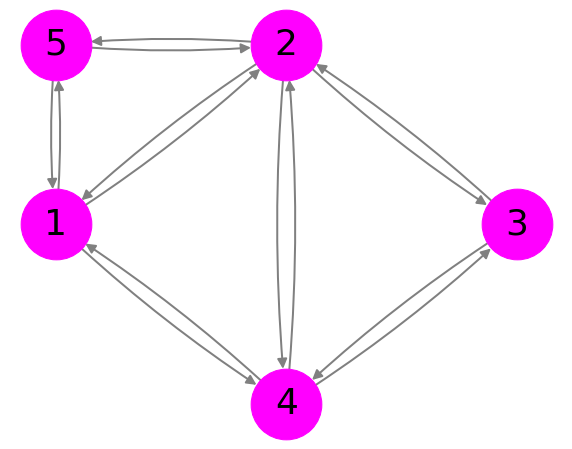

In [5]:
plt.rc("figure",figsize=(10,8))

pos = {1: (-1, 3), 2:(0.5, 6), 3: (2, 3), 4: (0.5, 0), 5: (-1,6)}

options = {
    "with_labels": True,
    "font_size": 36,
    "node_size": 5000,
    "node_color": "magenta",
    "edge_color": "grey",
    "arrowsize": 20,
    'width': 2,
    "connectionstyle": 'arc3, rad = 0.05'
}

fig, ax = plt.subplots()
nx.draw_networkx(G_ex1, pos, **options)

ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')
plt.show()
fig.savefig('G_ex1_diagram.png')

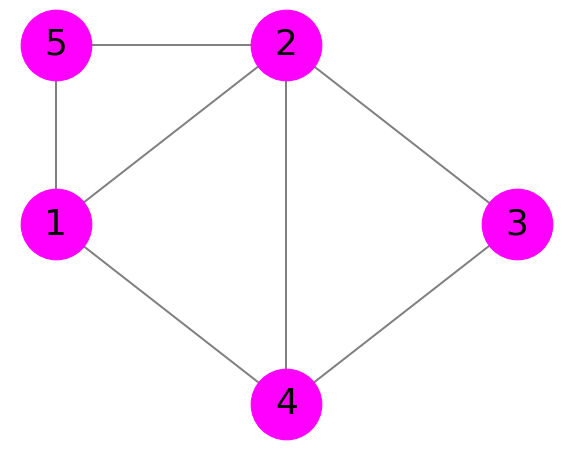

In [6]:
plt.rc("figure",figsize=(10,8))

pos = {1: (-1, 3), 2:(0.5, 6), 3: (2, 3), 4: (0.5, 0), 5: (-1,6)}

options = {
    "with_labels": True,
    "font_size": 36,
    "node_size": 5000,
    "node_color": "magenta",
    "edge_color": "grey",
    "arrowsize": 20,
    'width': 2,
    "connectionstyle": 'arc3, rad = 0.05'
}

fig, ax = plt.subplots()
nx.draw_networkx(G_ud1, pos, **options)

ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')
plt.show()
fig.savefig('G_ud1_diagram.png')

## Extract node, edge, weight, and cycle information from the graph

In [7]:
node_list = get_nodes(G_ex1)

In [8]:
edge_list = get_edges(G_ex1)

In [9]:
weight_dict, weight_list = get_weights(G_ex1)

In [10]:
cycle_list = get_cycle_nodes(G_ud1)

## Obtain the corresponding edge and weight information for each cycle

In [11]:
cycle_edges_forward, cycle_edges_backward, cycle_weights_forward, cycle_weights_backward = get_cycle_weights_edges(G_ud1,cycle_list,weight_dict)

## Calculate the affinities for each cycle in the graph

In [12]:
affinities_f, affinities_b = calculate_cycle_products(cycle_weights_forward,cycle_weights_backward)

In [13]:
total_affinities = calculate_affinities(affinities_f, affinities_b, cycle_list)

## Create an equilibrium parameter sampling algorithm for each cycle in the graph

I have to go back to the creation of weight_dict. There, if no weights are provided, I randomly sample integer weights from the range of values 0 to 100. In the OG `eq_param_sample` function, I randomly sample all but one weight, and then backcalculate the last one using the cycle condition. The question of which rate to choose to backcalculate is a tricky one, I think. But perhaps it doesn't matter as much as I think it should.

Let's think about this. A graph has $c$ cycles in it. Each cycle has a certain number of edges and nodes. Those edges are contained in `cycle_forward_edges` and `cycle_reverse_edges`. Ha!

So, let's say we just reassign the weights for cycle_forward_weights and cycle_reverse weights. And we just choose the last one each time? It should at least work properly for the majority of cases... and if it doesn't, we'll find out soon enough. 

In [14]:
print(cycle_weights_forward)

[[65, 69, 13], [74, 4, 13], [17, 6, 60]]


In [15]:
print(cycle_weights_backward)

[[82, 59, 28], [60, 52, 28], [72, 76, 74]]


In [16]:
print(cycle_edges_forward)

[[(2, 5), (5, 1), (1, 2)], [(2, 4), (4, 1), (1, 2)], [(2, 3), (3, 4), (4, 2)]]


In [17]:
print(cycle_edges_backward)

[[(5, 2), (1, 5), (2, 1)], [(4, 2), (1, 4), (2, 1)], [(3, 2), (4, 3), (2, 4)]]


This is even easier than I thought. We just have to alter the weight of the edge we want to back-calculate. And we can add a conditional statement to say that if an edge has already been re-calculated, choose the adjcent one instead. We have to reassign the value of one edge in either forward or reverse.

How do we calculate the affinity from these lists? `cycle_weights_forward[i][-1] = np.prod(cycle_weights_forward[i][:-1])/np.prod(cycle_weights_backward[i])`.

How do we keep track of the edges used? `edge_tracker.append(cycle_edges_forward[i][-1]`

In [18]:
    num_cycles = len(cycle_list)
    edge_tracker = []

    for i in range(num_cycles):
        if cycle_edges_forward[i][0] not in edge_tracker:
            cycle_weights_forward[i][0] = 1/(np.prod(cycle_weights_forward[i][1:])/np.prod(cycle_weights_backward[i]))
            edge_tracker.append(cycle_edges_forward[i][0])

In [19]:
print(cycle_weights_forward)

[[151.01895206243032, 69, 13], [1679.9999999999998, 4, 13], [1124.8, 6, 60]]


In [20]:
products_f, products_b = calculate_cycle_products(cycle_weights_forward,cycle_weights_backward)

In [21]:
# pre-adjustment
total_affinities = calculate_affinities(affinities_f, affinities_b, cycle_list)

In [22]:
print(total_affinities)

[-0.84301807 -3.12248398 -4.19214718]


In [23]:
# post-adjustment
total_affinities = calculate_affinities(products_f, products_b, cycle_list)

In [24]:
print(total_affinities)

[ 0.00000000e+00 -2.22044605e-16 -1.11022302e-16]


Ahahahaha. That didn't work like I hoped. The problem was with the `np.prod` function. When I simply multiplied the elements of the list, I got the expected result. Will need to find a more elegant way of generalizing this calculation. Another thing to keep in mind is that ideally, it would be nice to sample weights for the graph directly... but I can also create a function that resets the weights of the graph from these altered lists. These are adjustments for later. Right now, what I want to do is generate force-area plots for the three examples I sent to Jeremy.

In [25]:
def initial_equilibrium_parameter_set(cycle_list,cycle_edges_forward,cycle_weights_forward,cycle_weights_backward):
    
    num_cycles = len(cycle_list)
    edge_tracker = []
    
    for i in range(num_cycles):
        if cycle_edges_forward[i][0] not in edge_tracker:
            cycle_weights_forward[i][0] = 1/(np.prod(cycle_weights_forward[i][1:])/np.prod(cycle_weights_backward[i]))
            edge_tracker.append(cycle_edges_forward[i][0])
        
    return cycle_weights_forward, edge_tracker

In [26]:
cycle_weights_forward, edge_tracker = initial_equilibrium_parameter_set(cycle_list,cycle_edges_forward,cycle_weights_forward,cycle_weights_backward)

In [27]:
products_f, products_b = calculate_cycle_products(cycle_weights_forward,cycle_weights_backward)

In [28]:
total_affinities = calculate_affinities(products_f, products_b, cycle_list)

In [29]:
print(total_affinities)

[ 0.00000000e+00 -2.22044605e-16 -1.11022302e-16]


In [30]:
print(edge_tracker)

[(2, 5), (2, 4), (2, 3)]


## Create force-area plots

Prior to executing this function, the user should have extracted all relevant information from the graph. This includes the direction specific cycle weight and edge informtation.

In [31]:
# step 1: obtain the weight and cycle information 

In [32]:
weight_dict, weight_list = get_weights(G_ex1)

In [33]:
cycle_list = get_cycle_nodes(G_ud1)

In [34]:
# step 2: obtain the cycle-specific weight and edge information

In [35]:
cycle_edges_forward, cycle_edges_backward, cycle_weights_forward, cycle_weights_backward = get_cycle_weights_edges(G_ud1,cycle_list,weight_dict)

In [36]:
# step 3: initialize the system such that the weights obey detailed balance

In [37]:
cycle_weights_forward, edge_tracker = initial_equilibrium_parameter_set(cycle_list,cycle_edges_forward,cycle_weights_forward,cycle_weights_backward)

In [38]:
# step 4: check that the system is at equilibrium

In [39]:
products_f, products_b = calculate_cycle_products(cycle_weights_forward,cycle_weights_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0. 0. 0.]


In [40]:
# step 5: store the affinity values for each cycle in a 3xN array

In [41]:
N = 1000
all_affinities = np.zeros((N,3))
all_areas = np.zeros(N)

all_affinities[0] = total_affinities

In [43]:
#print(all_affinities)

In [191]:
# step 6: make weight_list from updated cycle_weights_forward

In [44]:
print(cycle_edges_forward)
print(cycle_weights_forward)
print(edge_tracker)

[[(2, 5), (5, 1), (1, 2)], [(2, 4), (4, 1), (1, 2)], [(2, 3), (3, 4), (4, 2)]]
[[92.50207125103563, 71, 17], [88.57466063348417, 26, 17], [4.533333333333333, 99, 15]]
[(2, 5), (2, 4), (2, 3)]


In [45]:
print(weight_dict)

{(1, 2): 17, (1, 4): 45, (1, 5): 77, (2, 1): 58, (2, 4): 66, (2, 3): 69, (2, 5): 18, (3, 2): 17, (3, 4): 99, (4, 2): 15, (4, 3): 6, (4, 1): 26, (5, 2): 25, (5, 1): 71}


In [46]:
for i in range(num_cycles):
    weight_dict[edge_tracker[i]] = cycle_weights_forward[i][0]

In [47]:
print(weight_dict)

{(1, 2): 17, (1, 4): 45, (1, 5): 77, (2, 1): 58, (2, 4): 88.57466063348417, (2, 3): 4.533333333333333, (2, 5): 92.50207125103563, (3, 2): 17, (3, 4): 99, (4, 2): 15, (4, 3): 6, (4, 1): 26, (5, 2): 25, (5, 1): 71}


In [48]:
weight_list = np.fromiter(weight_dict.values(), dtype=float)

In [49]:
# step 7: calculate Laplacian matrix from weight_list

In [50]:
num_nodes = len(node_list)
print(num_nodes)

5


In [51]:
num_edges = len(edge_list)
print(num_edges)

14


In [52]:
L = Laplacian_all(edge_list,weight_list,num_nodes,num_edges)

In [53]:
print(L)

[[-155.           17.            0.           45.           77.        ]
 [  58.          -74.            4.53333333   88.57466063   92.50207125]
 [   0.           17.          -10.53333333   99.            0.        ]
 [  26.           15.            6.         -232.57466063    0.        ]
 [  71.           25.            0.            0.         -169.50207125]]


In [54]:
# step 8: calculate the forward and reverse higher-order autocorrelation functions and store the area between them

In [59]:
observable_ex1 = [3, 5, 7, 9, 11]
tau_n = np.around(np.arange(0.01,2.0,step=.01), decimals = 2)

In [60]:
t_ex1, t_rev_ex1 = NG_III_autocorrelation_analytical(observable_ex1,L,tau_n,alpha=1,beta=3)

In [61]:
np.abs(np.trapz(t_ex1)-np.trapz(t_rev_ex1))

2.9336438075988553

In [62]:
# step 9 : repeat N times and perturb a particular parameter each time

In [63]:
    for cycle in cycle_weights_forward:
        cycle[0] += 1

In [64]:
cycle_weights_forward

[[93.50207125103563, 71, 17],
 [89.57466063348417, 26, 17],
 [5.533333333333333, 99, 15]]

In [65]:
for i in tqdm(range(N)):
    
    # perturb parameter in each cycle
    for cycle in cycle_weights_forward:
        cycle[0] += 1
    
    # calculate and store the cycle affinity for each cycle
    products_f, products_b = calculate_cycle_products(cycle_weights_forward,cycle_weights_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    
    all_affinities[i] = total_affinities
    
    # edit the record of the weights in the graph
    for i in range(num_cycles):
        weight_dict[edge_tracker[i]] = cycle_weights_forward[i][0]
    
    weight_list = np.fromiter(weight_dict.values(), dtype=float)
    
    # calculate the Laplacian
    L = Laplacian_all(edge_list,weight_list,num_nodes,num_edges)
    
    # calculate the autocorrelation functions
    t_ex1, t_rev_ex1 = NG_III_autocorrelation_analytical(observable_ex1,L,tau_n,alpha=1,beta=3)
    
    # calculate and store the area between them
    all_areas[i] = np.abs(np.trapz(t_ex1)-np.trapz(t_rev_ex1))

100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 17.96it/s]


In [66]:
# step 10: plot each cycle's affinity against the area difference

In [67]:
#print(all_affinities)
#print(all_affinities[:,0])

In [68]:
#print(all_areas)

In [71]:
# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(14,12))
%config InlineBackend.figure_format = 'retina'
#plt.style.use('dark_background')
#plt.rcParams.update({"figure.facecolor": "111111",
#                   "savefig.facecolor": "111111"})

Text(0.5, 1.0, 'Force-area plot')

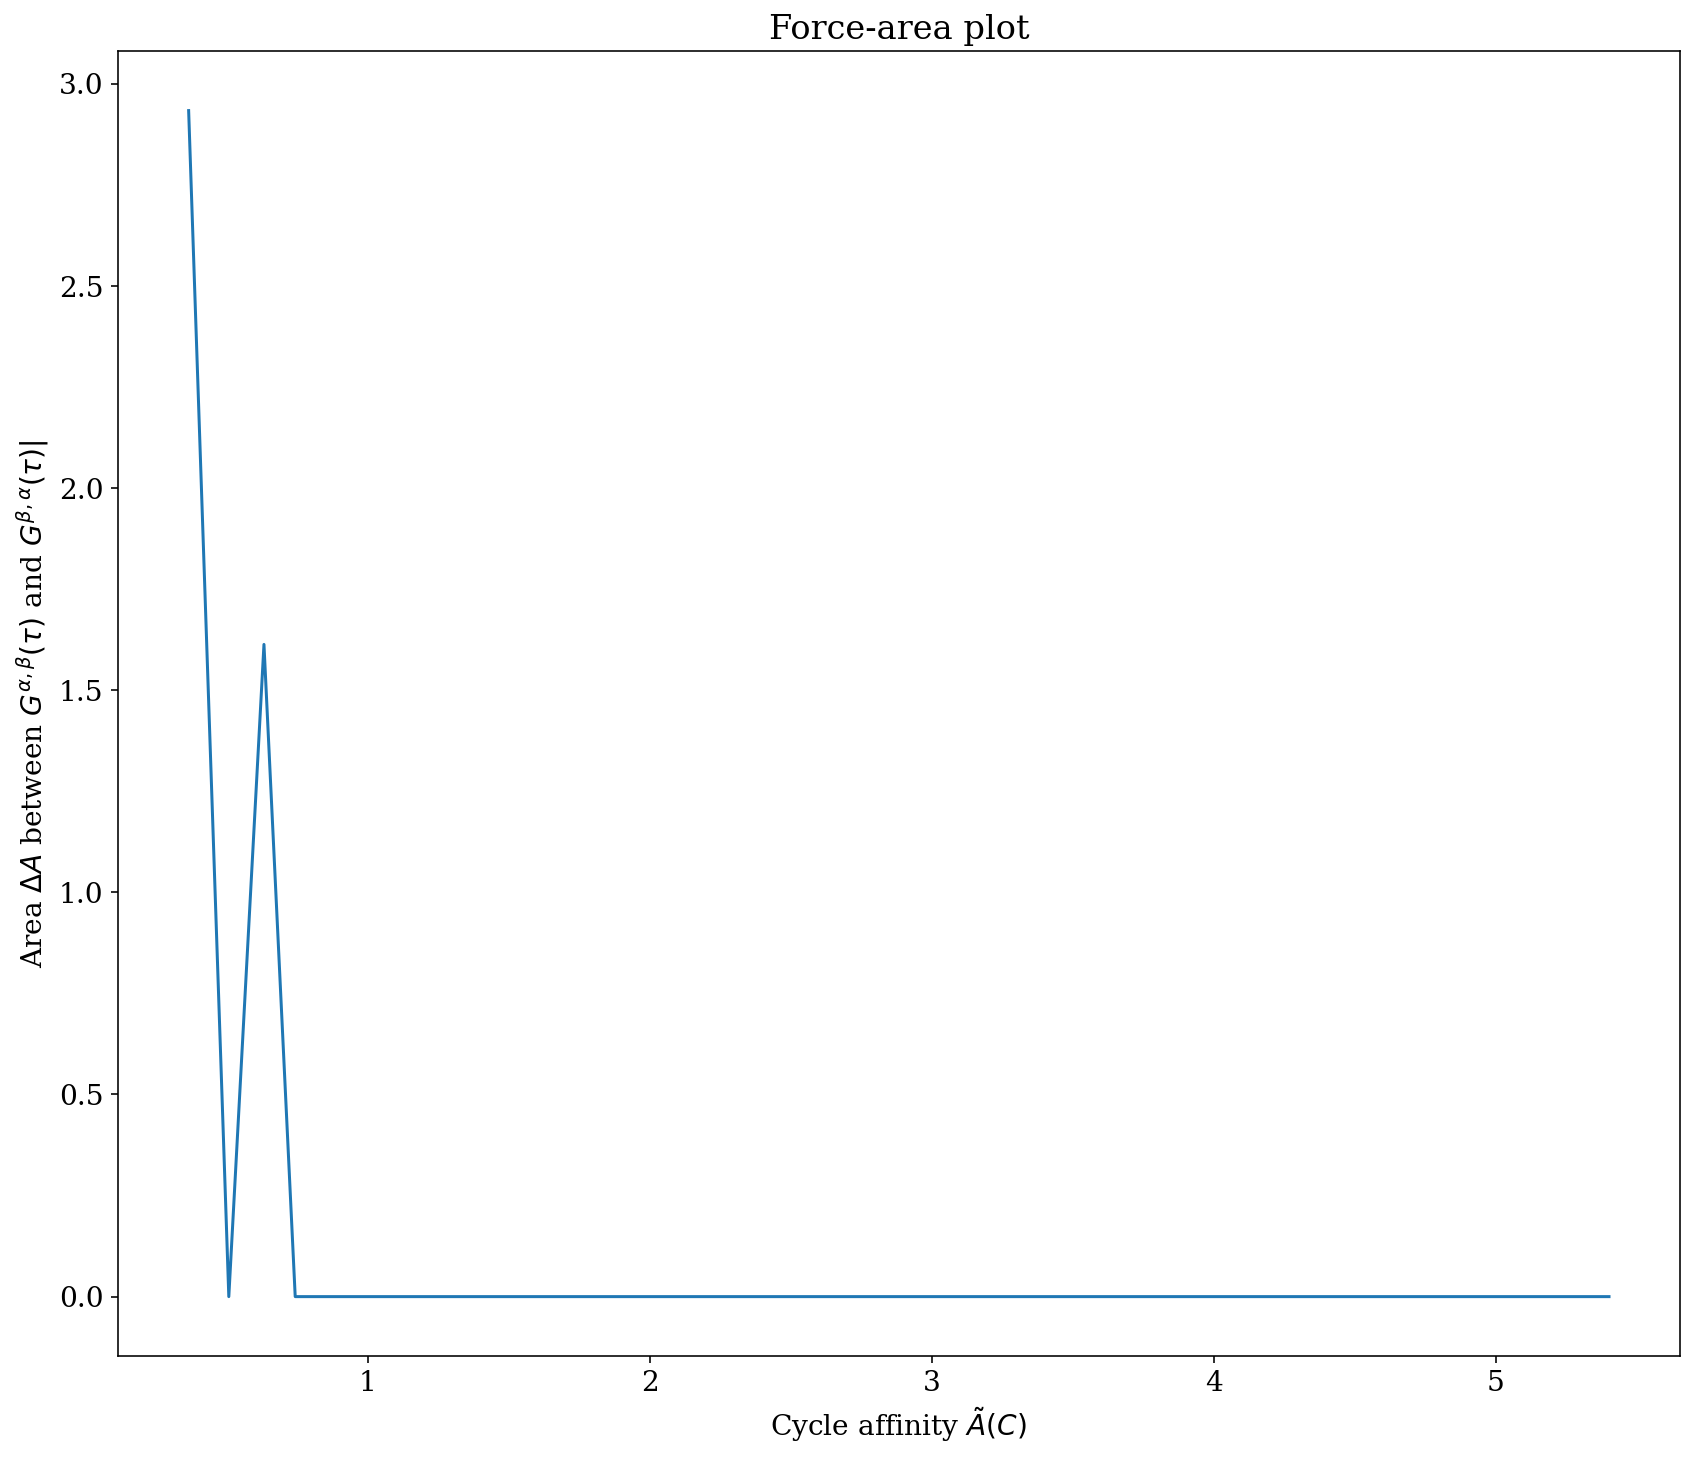

In [74]:
fig, ax = plt.subplots()
plt.plot(all_affinities[:,2],all_areas)
plt.xlabel(r'Cycle affinity $\tilde{A}(C)$')
plt.ylabel(r'Area $\Delta A$ between $G^{\alpha,\beta}(\tau)$ and $G^{\beta,\alpha}(\tau)|$')
plt.title(r'Force-area plot')
#fig.savefig('G_ex1_cycle1.png')

## Troubleshooting force-area plots

Need to double check the area calculation. Something isn't going right here.